In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Import pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [78]:
x_train = pd.read_csv('windforecasts_wf1.csv', index_col='date')
y_train = pd.read_csv('train.csv')
# just consider the wind farm 1

In [79]:
# Select power data set
y_train['date'] = pd.to_datetime(y_train.date, format= '%Y%m%d%H')
y_train.index = y_train['date'] 
y_train.drop('date', inplace = True, axis = 1)
complete_ts = y_train[:'2011-01-01 00'] # all the data without any gaps
y_train_update=complete_ts[1:]

In [92]:
x_train_update.index

DatetimeIndex(['2009-07-01 00:00:00', '2009-07-01 00:00:00',
               '2009-07-01 00:00:00', '2009-07-01 00:00:00',
               '2009-07-01 00:00:00', '2009-07-01 00:00:00',
               '2009-07-01 00:00:00', '2009-07-01 00:00:00',
               '2009-07-01 00:00:00', '2009-07-01 00:00:00',
               ...
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00',
               '2010-12-31 12:00:00', '2010-12-31 12:00:00'],
              dtype='datetime64[ns]', name='date', length=13176, freq=None)

In [108]:
# Select forecast data set
x_train_update = x_train[x_train.hors<=12]
x_train_update.index = pd.to_datetime(x_train_update.index, format= '%Y%m%d%H')
x_train_update = x_train_update[:'2010-12-31 12']
x_train_update['time'] = x_train_update.index + pd.to_timedelta(x_train_update.hors,"H")

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
date,,,,,,,
2009-07-01 01:00:00,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2009-07-01 02:00:00,0.020,0.175,0.178,0.033,0.015,0.026,0.000
2009-07-01 03:00:00,0.060,0.085,0.109,0.022,0.010,0.013,0.000
2009-07-01 04:00:00,0.045,0.032,0.079,0.039,0.010,0.000,0.000
2009-07-01 05:00:00,0.035,0.011,0.099,0.066,0.015,0.013,0.000
...,...,...,...,...,...,...,...
2010-12-31 20:00:00,0.536,0.069,0.929,0.749,0.794,0.921,0.884
2010-12-31 21:00:00,0.662,0.048,0.702,0.837,0.738,0.895,0.884
2010-12-31 22:00:00,0.817,0.016,0.820,0.749,0.799,0.868,0.859


In [138]:
# Augmentation of data for high wind speeds
x_train_high_ws = x_train_update[x_train_update.ws>6]
x_train_augmented = pd.concat([x_train_high_ws,x_train_update[x_train_update.ws<6][:len(x_train_high_ws)]],axis=0)
x_train_augmented = x_train_augmented.sort_values(by='time')
y_train_augmented = y_train_update[y_train_update.index.isin(x_train_augmented.time)]

In [163]:
# FFNN Day Ahead
# Define the FFNN network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # input 
        self.inputLay = nn.Linear(in_features = 1,
                               out_features = 128,
                               bias = True)
        self.hidden_layer = nn.Linear(in_features = 128,
                                      out_features = 128,
                                      bias = True)
        self.hidden_layer2 = nn.Linear(in_features = 128,
                              out_features = 128,
                              bias = True)
        self.output = nn.Linear(in_features = 128,
                               out_features = 1,
                               bias = True)

    def forward(self, x):
      x = self.inputLay(x)
      x = F.elu(x) # F = nn.Functional
      x = self.hidden_layer(x)
      x = F.elu(x)
      x = self.hidden_layer2(x)
      x = F.elu(x)
      out = self.output(x)

      return out



In [164]:
FFNN_mapping = Net()
print(FFNN_mapping)

Net(
  (inputLay): Linear(in_features=1, out_features=128, bias=True)
  (hidden_layer): Linear(in_features=128, out_features=128, bias=True)
  (hidden_layer2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)


In [165]:
# Test the FFNN
FFNN_mapping(   torch.Tensor(np.array([x_train_update.ws.iloc[0:6]]).T)    )

tensor([[-0.0774],
        [-0.0261],
        [-0.1084],
        [-0.2983],
        [-0.4986],
        [-0.5308]], grad_fn=<AddmmBackward0>)

In [166]:
# Set the parameters for training

FFNN_mapping = Net()
# Convert to cuda if GPU available
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    FFNN_mapping.cuda()

# Define loss function and train parameters
criterion = nn.MSELoss()    

# Adam gradient descent with learning rate decay
optimizer = optim.Adam(FFNN_mapping.parameters(), lr=1e-4)

# Length of the training and batches
epochs = 50
batch_size = 8
num_batch = len(x_train_augmented)//batch_size

# Function to get the batch
get_batch = lambda i, size: range(i * size, (i + 1) * size)

# Track loss
training_RMSE = []


In [167]:
# Training

# Loop over epochs
for i in range(epochs):

    epoch_training_loss = 0

    FFNN_mapping.train()

    # For each sequence in training set
    for b in range(num_batch):

      batch_index = get_batch(b,batch_size)
                 
      # Get inputs and targets
      inputs = torch.transpose(torch.Tensor([np.array(x_train_augmented.ws)[batch_index]]),0,1) # wind speed
      targets = torch.Tensor(np.array(y_train_augmented.wp1)[batch_index])  # power

      # Convert to cuda to run on GPU
      if torch.cuda.is_available():
            inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())

      # Forward pass
      outputs = FFNN_mapping(inputs)
          
      # Compute loss
      loss = criterion(outputs, targets)
          
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
          
      # Update loss
      if torch.cuda.is_available():
        epoch_training_loss += loss.cpu().detach().numpy()
      else:
        epoch_training_loss += loss.detach().numpy()
    
    # Save loss for plot
    epoch_RMSE = np.sqrt(epoch_training_loss/(num_batch))
    training_RMSE.append(epoch_RMSE)

    # Compute confidence interval
    # CI = [norm.ppf(0.025)*training_RMSE[-1],norm.ppf(0.975)*training_RMSE[-1]]

    # Print loss every 10 epochs
    if i % 1 == 0:
        print('Epoch %d, training RMSE: %.3f' % (i+1,training_RMSE[-1]))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, training RMSE: 4.320
Epoch 2, training RMSE: 0.361
Epoch 3, training RMSE: 0.247
Epoch 4, training RMSE: 0.234
Epoch 5, training RMSE: 0.249
Epoch 6, training RMSE: 0.247
Epoch 7, training RMSE: 0.284
Epoch 8, training RMSE: 0.268
Epoch 9, training RMSE: 0.281
Epoch 10, training RMSE: 0.286
Epoch 11, training RMSE: 0.292
Epoch 12, training RMSE: 0.284
Epoch 13, training RMSE: 0.291
Epoch 14, training RMSE: 0.301
Epoch 15, training RMSE: 0.280
Epoch 16, training RMSE: 0.295
Epoch 17, training RMSE: 0.294
Epoch 18, training RMSE: 0.283
Epoch 19, training RMSE: 0.287
Epoch 20, training RMSE: 0.285
Epoch 21, training RMSE: 0.285
Epoch 22, training RMSE: 0.285
Epoch 23, training RMSE: 0.287
Epoch 24, training RMSE: 0.292
Epoch 25, training RMSE: 0.281
Epoch 26, training RMSE: 0.284
Epoch 27, training RMSE: 0.279
Epoch 28, training RMSE: 0.296
Epoch 29, training RMSE: 0.272
Epoch 30, training RMSE: 0.284
Epoch 31, training RMSE: 0.277
Epoch 32, training RMSE: 0.280
Epoch 33, trainin

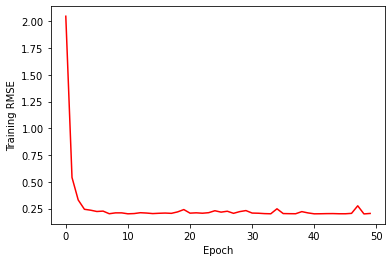

In [153]:
# Plot training loss
epoch = np.arange(len(training_RMSE))
plt.figure()
plt.plot(epoch, training_RMSE, 'r')
plt.xlabel('Epoch'), plt.ylabel('Training RMSE')
plt.show()

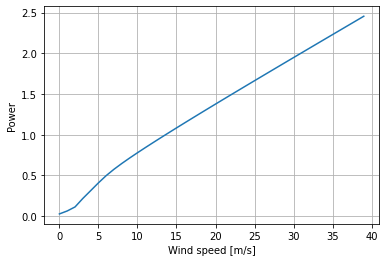

In [145]:
# Plot the learnt power curve
power = []
v = []
for i in range(40):
  v.append(i)
  power.append(FFNN_mapping(torch.Tensor([i])).detach().numpy())

plt.plot(v,power)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power')
plt.grid()

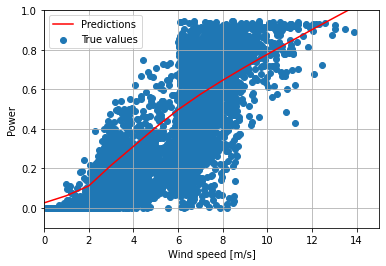

In [147]:
# Scatter plot of the power as function of wind speed
plt.scatter(x_train_augmented.ws,y_train_augmented.wp1,label='True values')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power')
plt.grid()
plt.plot(v,power,'r',label='Predictions')
plt.xlim([0, 15])
plt.ylim([-0.1, 1])
plt.legend()